***
# <font color=green size=10>Lista 2: Inferência estatística via simulação</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
from scipy import stats, optimize

import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns

**Definindo constantes globais.**

In [2]:
# valor da semente padrão
SEED = 42

**Montando o dataset da lista.**

In [3]:
# carrega os arquivos csv originais
climbing_statistics = pd.read_csv("climbing_statistics.csv")
rainier_weather = pd.read_csv("Rainier_Weather.csv")

# junta os arquivos, elimina linhas e colunas desnecessárias e renomeia colunas
dados_completos = climbing_statistics.merge(rainier_weather, left_on="Date", right_on="Date", how="left")
dados_completos = dados_completos.drop(["Success Percentage", "Battery Voltage AVG"], axis=1)
dados_completos = dados_completos.query("Attempted >= Succeeded")
dados_completos = dados_completos.rename(columns={"Date": "Data", "Succeeded": "Sucessos", "Attempted": "Tentativas",
                              "Temperature AVG": "Temperatura", "Relative Humidity AVG": "Umidade_relativa",
                              "Wind Speed Daily AVG": "Velocidade_vento", "Wind Direction AVG": "Direc_vento",
                              "Solare Radiation AVG": "Radiacao_solar"})

# aplica as transformações nos dados
dados_completos.Temperatura = (dados_completos.Temperatura - 32) * 5 / 9
dados_completos["Cleaver"] = dados_completos.Route == "Disappointment Cleaver"
dados_completos.Data = pd.to_datetime(dados_completos.Data)

# reordena as colunas de acordo com o layout definido para a lista
dados_completos = dados_completos.reindex(columns=["Data", "Sucessos", "Route", "Tentativas", "Temperatura", "Umidade_relativa",
                               "Velocidade_vento", "Direc_vento", "Radiacao_solar", "Cleaver"])

___

"O Monte Rainier é um estratovulcão, e a montanha mais alta do estado norte-americano de Washington.(. . . ) Sua altitude é de 4392m e, em dias de tempo claro, seu pico permanentemente nevado pode ser facilmente avistado de Seattle e outras cidades da região." (*wikipédia*)

Um conjunto de dados sobre tentativas de se escalar o Monte Rainier está disponível no site *Kaggle*, e pode ser obtido pelo link [https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3).

Usaremos Modelos Lineares Generalizados para descrever como o número de montanhistas que alcançam o cume do monte em um dado dia (sucessos) varia em função da temperatura média do ar (em graus Celsius).

A seguir apresentamos a estrutura do banco de dados.

In [4]:
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 0 to 4076
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              4067 non-null   datetime64[ns]
 1   Sucessos          4067 non-null   int64         
 2   Route             4067 non-null   object        
 3   Tentativas        4067 non-null   int64         
 4   Temperatura       1889 non-null   float64       
 5   Umidade_relativa  1889 non-null   float64       
 6   Velocidade_vento  1889 non-null   float64       
 7   Direc_vento       1889 non-null   float64       
 8   Radiacao_solar    1889 non-null   float64       
 9   Cleaver           4067 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 321.7+ KB


Considere o modelo $$Y_{ij} \sim Poisson(\lambda_{ij})\\ \lambda_{ij} = exp(\alpha + \beta t_{i}),$$

onde $Y_{ij}$ representa o número de montanhistas que atingiram o cume pela rota $j$ no dia $i$, $\alpha$ e $\beta$ são parâmetros desconhecidos do modelo e $t_{i}$ indica a temperatura média no dia $i$. Para uma determinada temperatura, o modelo prevê o mesmo valor para todas as rotas. Desconsidere os dados da rota *glacier only - no summit attempt*. Por fim, note que para obter o valor de $y_{ij}$ é preciso somar todos os sucessos registrados no dia $i$ para a rota $j$.

In [5]:
dados = dados_completos.query("Route != 'glacier only - no summit attempt'")

## Questão 1)

### a)

___

Conduza um teste de hipóteses por simulação para avaliar a hipótese nula de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente).


In [6]:
dados.groupby(["Cleaver"]).agg({"Sucessos": ["sum", "mean", "count"]})

Sucessos                
             sum      mean count
Cleaver                         
False       2668  2.082748  1281
True        8246  3.031618  2720

In [7]:
dados.query("Sucessos > 0").groupby(["Cleaver"]).agg({"Sucessos": ["sum", "mean", "count"]})

Sucessos                
             sum      mean count
Cleaver                         
False       2668  4.214850   633
True        8246  5.093267  1619

In [8]:
diferenca_real = abs(4.214850 - 5.093267)
diferenca_real

0.8784169999999998

In [9]:
lista = dados.query("Sucessos > 0").Sucessos.tolist()
diferencas = []

for i in range(1001):
    lista_sorteada = np.random.choice(lista, size=1619 + 633, replace=False)
    media_true = np.mean(lista_sorteada[:1619])
    media_false = np.mean(lista_sorteada[1620:])
    diferencas.append(abs(media_true - media_false))

<AxesSubplot:ylabel='Density'>

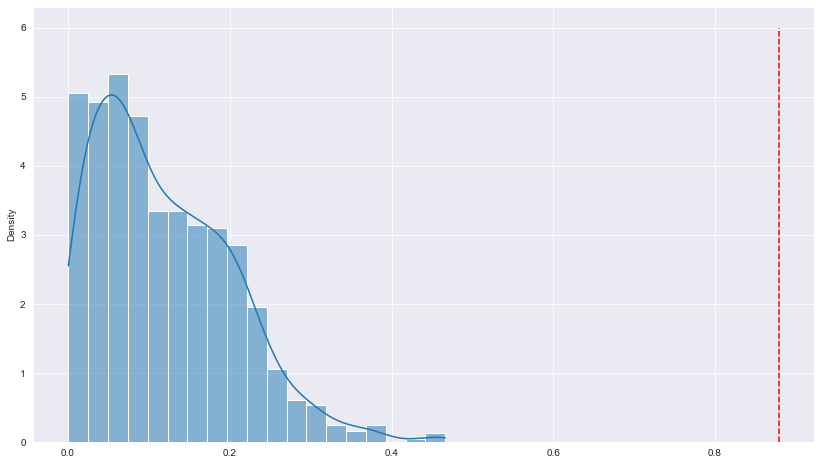

In [10]:
ax = sns.histplot(diferencas, kde=True, stat="density")
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferenca_real, ymin=0, ymax=6, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

### b)

___

Obtenha o estimador de máxima verossimilhança de $\alpha$ e $\beta$ considerando o modelo proposto. Dica: Use a função $\textsf{optim}$ do $\textbf{\textsf{R}}$ para achar o ponto que maximiza a log-verossimilhança.

In [11]:
dados_poisson = dados.groupby(["Data", "Temperatura"]).Sucessos.sum()
dados_poisson = pd.DataFrame(dados_poisson)
dados_poisson.reset_index(inplace=True)

dados_poisson.head()

,Data,Temperatura,Sucessos
0,2014-09-23,0.476296,0
1,2014-09-24,-1.276157,0
2,2014-09-25,-2.875694,8
3,2014-09-26,-2.089815,19
4,2014-09-27,0.732639,25


In [18]:
def menos_somatorio_log_verossimilhanca(parametros):
    alfa, beta = parametros

    lambda_previsto = np.exp(alfa + beta * dados_poisson.Temperatura)
    log_verossimilhanca = stats.poisson.logpmf(dados_poisson.Sucessos, lambda_previsto)

    return -1 * np.sum(log_verossimilhanca)

In [17]:
# Minimiza a função negativa de log verossimilhanca
emv = optimize.minimize(menos_somatorio_log_verossimilhanca, np.array([0, 0]))

# Obtem e imprime os valores de alfa e beta
emv_alfa = emv.x[0]
emv_beta = emv.x[1]
print(f"Alfa: {emv_alfa:0.4f}")
print(f"Beta: {emv_beta:0.4f}")

Alfa: 2.7431
Beta: 0.1122


Comparando o resultado da maximização da função de log-verossimilhança com os valores de alfa e beta gerados pela biblioteca statsmodels.

In [14]:
modelo_poisson = smf.poisson(formula="Sucessos ~ Temperatura", data=dados_poisson)
modelo_poisson_ajustado = modelo_poisson.fit()

print(f"Alfa: {modelo_poisson_ajustado.params[0]:0.4f}")
print(f"Beta: {modelo_poisson_ajustado.params[1]:0.4f}")

Optimization terminated successfully.
         Current function value: 14.276702
         Iterations 6
Alfa: 2.7431
Beta: 0.1122


<font color='red'>**Resposta:**</font>

O estimador de máxima verossimilhança para $\alpha$ é 2,7431 e $\beta$ é 0,1122.

### c)

___

Estime a distribuição de probabilidade do número de sucessos previstos para um dia em que a temperatura seja de 15 graus.

In [15]:
print(int(np.exp(emv_alfa + emv_beta * 15)))

83


### d)

___

Construa um intervalo de confiança de 95% para $exp(\beta)$ a partir do método de bootstrap paramétrico. Interprete o resultado considerando o contexto dos dados. Dica: calcule o aumento percentual da média esperada quando a temperatura aumenta em 1 grau Celsius.

### e)

___

Faça um diagnóstico do modelo via simulação. Para tanto, gere dados sintéticos usando o modelo obtido no item $\textsf{b)}$, ajuste um novo modelo sobre os dados sintéticos e calcule o Erro quadrático médio(MSE). Repita esse procedimento 10000 vezes e compare os MSEs gerados com aquele do modelo obtidoem $\textsf{b)}$. Comente os resultados.

## Questão bônus


Use o método de integração por Monte Carlo para estimar o volume de uma elipsoide definida por $$\frac{x^{2}}{2} + \frac{y^{2}}{3} + \frac{z^{2}}{4} = 1.$$